*Hubert Kaczyński; nr albumu 331386; grupa 101*
# **WSI laboratorium 6. Uczenie ze wzmocnieniem**

Poniżej znajdują się analizy przygotowanej przeze mnie implementacji optymalnej polityki sprzedaży, bazując na problemie decyzyjnym Markova dla problemu sprzedawcy.

## **Problem decyzyjny Markova**

Problem decyzyjny Markova jest matematycznym modelem używanym w uczeniu ze wzmocnieniem. Opisuje on sposób podejmowania decyzji agenta (decydenta), które wpływają na stan środowiska. Każda decyzja ma wpływ na przyszłe możliwości jak i natychmiastowe nagrody.

Używa się czterech głównych elementów $⟨X,A,ϱ,σ⟩$ fo określenia problemu decyzyjnego Markova.
- $X$ to skończony zbiór stanów $s$, w którch może znaleźć się agent,
- $A$ to skończony zbiór akcji, które może podjąć agent,
- $ϱ(x,a)$ to funkcja wzmocnienia. Określa ona jaką nagrodę dostanie agent, będąc w stanie $x$ i podejmując akcję $a$,
- $σ(x,a)$ to funkcja przejść stanów.

Istotną częścią problemu jest własność Markova, która mówi, że w każdym kroku kolejny stan i nagroda zależą wyłącznie od stanu aktualnego. Nieistotne są w tym wypadku poprzednie działania agenta.

Zasady wg których agent wybiera akcje określa polityka agenta (lub strategia agenta). Oznacza się ją funkcją $ π : X → A $. Zadanie ma na celu zbadanie optymalnej $π$ dla agenta w różnych scenariuszach dla danego problemu. Przez skończony horyzont najlepsza polityka jest polityką niestacjonarną. Wartość horyzontu wpływa na kształt polityki optmalnej.

## **Zadany problem**

W ramach zadania agent reprezentuje sprzedawcę w sklepie. Wykonuje on decyzje w kontekście sprzedaży lub zakupu dla różnych produktów. Chce maksymalizować zyskane nagrody w określonym horyzoncie czasowym. Ilość dostępnych produktów wyrażona jest poziomem zapasów $s$, który zawiera się w przedziale $[0; 10]$.

W każdym kroku agent wybiera jedną z dwóch akcji - kupno, czyli zwiększenie zapasu o 1 oraz sprzedaż, czyli zmniejszenie zapasu o 1. Sprzedaż generuje nagrodę +1, kupno nie generuje nagrody. Gdy zapas dotrze do maksymalnego poziomu 10, to generowana jest nagroda +100, co kończy problem. Na starcie poziom zapasów wynosi 3.

Agent może wykonać ograniczoną ilośc kroków. Tym ograniczeniem jest horyzont $H$, który określa liczbę kroków czasowych, przez które może działać agent. Wykorzystanie całego horyzontu kończy problem.

## **Implementacja**

Enumeracja `Action` przedstawia decyzje kupna i sprzedaży, które agent może podjąć w każdym kroku.

Postanowiłem przedstawić środowikso, w którym będzie działał agent jako klasę `Agent`. Określa ona m.in. początkową liczbę produktów, maksymalną liczbę zapasów i horyzont czasowy $H$.

Metoda `get_available_actions()` zwraca listę możliwych do wykonania akcji. Pozwala ona również na łatwą implementację większej ilości akcji w przyszłości w połączeniu z klasą enumeracji.

Metoda `optimal_strategy()` jest główną metodą, pozwalającą na znalezienie optymalnej polityki. W tym celu stosuję programowanie dynamiczne, które polega na podziale problemu na podproblemy. Podproblemy rozwiązywane będą od najmniejszego do największego więc rozwiązanie ostatniego z rozpatrywanych podproblemów będzie rozwiązaniem całości. Metoda sprawdza wstecz od czasu $H-1$ do 0 wszystkie możliwe akcje i wyznacza te optymalne. Tablica wartości `Values` przechowuje wartości akcji, czyli łączną sumę nagród, dla każdej kombinacji stanu i pozostałego czasu. Wynikiem jest słownik `strategy`, który dla każdej kombinacji przypisuje optymalną akcję.

Metoda `run_strategy()` symuluje znalezioną optymalną politykę, tym razem idąc poprawnie z czasem.

Metoda `print_simulation()` pozwala jasnie przedstawić przebieg akcji.


In [37]:
from enum import Enum
import numpy as np

class Action(Enum):
    SELL = 0
    BUY = 1

class Agent:
    def __init__(self, H):
        self.initial_s = 3
        self.max_s = 10
        self.H = H
    
    def get_available_actions(self, state):
        return [
            action
            for action in Action
            if (action == Action.SELL and state > 0) or (action == Action.BUY and state < self.max_s)
        ]
    
    def optimal_strategy(self):
        # Table for each state and time left
        Values = np.zeros((self.max_s + 1, self.H + 1))
        strategy = {}

        for remaining_time in reversed(range(self.H)):
            for state in range(self.max_s + 1):
                if state == self.max_s:
                    continue

                # Check all possible actions
                possible_actions = self.get_available_actions(state)
                best_value = -np.inf
                best_action = None

                # For each action, calculate the value
                for action in possible_actions:
                    if action == Action.SELL and state > 0:
                        next_state = state - 1
                        reward = 1
                    elif action == Action.BUY and state < self.max_s:
                        next_state = state + 1
                        if next_state == self.max_s:
                            reward = 100
                        else:
                            reward = 0
                    else:
                        continue

                    # Calculate the overall value of the action
                    value = reward + Values[next_state, remaining_time + 1]

                    if value > best_value:
                        best_value = value
                        best_action = action

                # Update the value and strategy
                Values[state, remaining_time] = best_value
                strategy[(state, remaining_time)] = best_action

        return strategy
    
    
    def run_strategy(self, strategy):
        state = self.initial_s
        total_reward = 0
        states = [state]
        actions = []

        # Run the strategy until the end of the horizon
        for h in range(self.H):
            action = strategy.get((state, h))
            if action is None or state == self.max_s:
                break

            if action == Action.SELL and state > 0:
                next_state = state - 1
                reward = 1
            elif action == Action.BUY and state < self.max_s:
                next_state = state + 1
                if next_state == self.max_s:
                    reward = 100
                else:
                    reward = 0
            else:
                continue
        
            state = next_state
            total_reward += reward

            states.append(state)
            actions.append(action)

        return states, actions, total_reward
    
    def print_simulation(self, strategy):
        states, actions, total_reward = self.run_strategy(strategy)

        print(f"\nSimulation for horizon H={self.H}")
        print(f"Initial state: {states[0]}")

        for i, (state, action) in enumerate(zip(states, actions)):
            next_state = states[i + 1] 
            action_str = "SELL" if action == Action.SELL else "BUY"
            print(f"Step {i + 1} | State: {state} | Action: {action_str} | Next state: {next_state}")

        print(f"Final state: {states[-1]}")
        print(f"Total reward: {total_reward}")

Przykładowe wywołanie algorytmu dla H=4:

In [38]:
my_agent = Agent(4)
strategy = my_agent.optimal_strategy()
my_agent.print_simulation(strategy)


Simulation for horizon H=4
Initial state: 3
Step 1 | State: 3 | Action: SELL | Next state: 2
Step 2 | State: 2 | Action: SELL | Next state: 1
Step 3 | State: 1 | Action: SELL | Next state: 0
Step 4 | State: 0 | Action: BUY | Next state: 1
Final state: 1
Total reward: 3


Widać, że w sytuacji, gdy agent nie jest w stanie dotrzeć do maksymalnego magazynu (nagroda 100), po prostu sprzedaje ile może, zyskując za każdym razem nagrodę 1. Postępuje on więc zgodnie z oczekiwaniami.

Co innego dzieje się przy większym horyzoncie H=7 pozwalającym na wypełnienie magazynu:

In [39]:
my_agent = Agent(7)
strategy = my_agent.optimal_strategy()
my_agent.print_simulation(strategy)


Simulation for horizon H=7
Initial state: 3
Step 1 | State: 3 | Action: BUY | Next state: 4
Step 2 | State: 4 | Action: BUY | Next state: 5
Step 3 | State: 5 | Action: BUY | Next state: 6
Step 4 | State: 6 | Action: BUY | Next state: 7
Step 5 | State: 7 | Action: BUY | Next state: 8
Step 6 | State: 8 | Action: BUY | Next state: 9
Step 7 | State: 9 | Action: BUY | Next state: 10
Final state: 10
Total reward: 100


Tym razem agent wyłącznie kupuje, co pozwala mu zdobyć wielką nagrodę 100.

Gdy horyzont jest jeszcze większy, np. H=12:

In [40]:
my_agent = Agent(12)
strategy = my_agent.optimal_strategy()
my_agent.print_simulation(strategy)


Simulation for horizon H=12
Initial state: 3
Step 1 | State: 3 | Action: SELL | Next state: 2
Step 2 | State: 2 | Action: SELL | Next state: 1
Step 3 | State: 1 | Action: BUY | Next state: 2
Step 4 | State: 2 | Action: BUY | Next state: 3
Step 5 | State: 3 | Action: BUY | Next state: 4
Step 6 | State: 4 | Action: BUY | Next state: 5
Step 7 | State: 5 | Action: BUY | Next state: 6
Step 8 | State: 6 | Action: BUY | Next state: 7
Step 9 | State: 7 | Action: BUY | Next state: 8
Step 10 | State: 8 | Action: BUY | Next state: 9
Step 11 | State: 9 | Action: BUY | Next state: 10
Final state: 10
Total reward: 102


Program słusznie zauważa, że szybkie dotarcie do pełnego magazynu skończyłoby przedwczesnie program więc wpierw korzysta póki może sprzedając.

### **Wnioski**

Dzięki programowaniu dynamicznemu agent postępuje logicznie i zgodnie z założeniami, zbadawszy możliwości. Odnalezione polityki są najoptymalniejsze.

## **Analiza działania**

Poniżej przedstawiam analizę wyników implementacji w zależności od horyzontu czasowego.

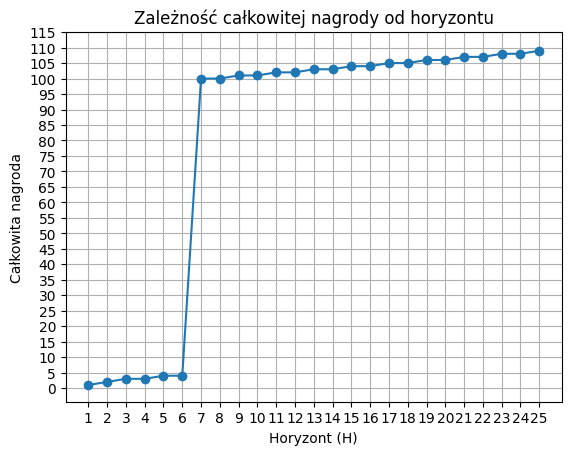

In [41]:
import matplotlib.pyplot as plt

def analyse(h_values):
    results = {}

    for H in h_values:
        my_agent = Agent(H)
        strategy = my_agent.optimal_strategy()
        states, actions, total_reward = my_agent.run_strategy(strategy)
        results[H] = {"strategy":strategy, "states": states, "actions": actions, "total_reward": total_reward}

    return results

results = analyse(range(1, 26))

def plot_rewards(results):
    h_values = list(results.keys())
    rewards = [result["total_reward"] for result in results.values()]

    plt.plot(h_values, rewards, marker="o")
    plt.xlabel("Horyzont (H)")
    plt.ylabel("Całkowita nagroda")
    plt.xticks(h_values)
    plt.yticks(range(0, 120, 5))
    plt.title("Zależność całkowitej nagrody od horyzontu")
    plt.grid()
    plt.show()

plot_rewards(results)

### **Wnioski**

Zachowanie wyników dla horyzontów do $H=7$ przedstawiłem wcześniej. Natomiast dla Horyzontów od 7 wzwyż pojawia się ciekawa zależność. Wartość całkowitej nagrody zmienia się co drugą wartość horyzontu - $H=7, 8, 11$. Wynika to stąd, że żeby móc sprzedać towar i otrzymać nagrodę, wpierw należy mieć co sprzedać. Zatem na ostateczną zmianę nagrody składają się dwa ruchy. Można tym samym wyliczyć wartość nagrody całkowitej dla dowolnej wartości horyzontu $H >= 7$:

$Calkowita nagroda = 100 + (H - 7) // 2$

Dla wartości $H = 167$ daje to całkowitą nagrodę 180. Sprawdzam poniżej:

In [42]:
my_agent = Agent(167)
strategy = my_agent.optimal_strategy()
my_agent.print_simulation(strategy)


Simulation for horizon H=167
Initial state: 3
Step 1 | State: 3 | Action: SELL | Next state: 2
Step 2 | State: 2 | Action: SELL | Next state: 1
Step 3 | State: 1 | Action: SELL | Next state: 0
Step 4 | State: 0 | Action: BUY | Next state: 1
Step 5 | State: 1 | Action: SELL | Next state: 0
Step 6 | State: 0 | Action: BUY | Next state: 1
Step 7 | State: 1 | Action: SELL | Next state: 0
Step 8 | State: 0 | Action: BUY | Next state: 1
Step 9 | State: 1 | Action: SELL | Next state: 0
Step 10 | State: 0 | Action: BUY | Next state: 1
Step 11 | State: 1 | Action: SELL | Next state: 0
Step 12 | State: 0 | Action: BUY | Next state: 1
Step 13 | State: 1 | Action: SELL | Next state: 0
Step 14 | State: 0 | Action: BUY | Next state: 1
Step 15 | State: 1 | Action: SELL | Next state: 0
Step 16 | State: 0 | Action: BUY | Next state: 1
Step 17 | State: 1 | Action: SELL | Next state: 0
Step 18 | State: 0 | Action: BUY | Next state: 1
Step 19 | State: 1 | Action: SELL | Next state: 0
Step 20 | State: 0 |

Wynik się zgadza. Można zatem stwierdzić, że im większa wartośc parametru $H$ tym zwiększa się nagroda, a zachowanie agenta wygląda następująco dla startowej ilości produktu $s = 3$:

Gdy $H < 7$:

Agent skupia się wyłącznie na próbie sprzedaży jak najwięcej razy, kupując tylko gdy towar się skończy.

Gdy $H = 7$:

Agent wyłącznie kupuje produkty, bo doprowadza go to do gigantycznej nagrody 100.

Gdy $H > 7$:

Agent wpierw kupuje i sprzedaje ile może, tak aby na końcu zmieścić kupno towaru do momentu zapełnienia magazynu. Zyskuje w ten sposób +100 nagrody do zdobytych już nagród za sprzedaż. Takie właśnie zachowanie zaprezentowałem wzorem w sekcji wyżej.